# Incorporating odds data

We investigate the effect on model performance of using next match odds data from oddsportal

## Set-up

In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 42

## Current model

In [6]:
current_lstm_model = load_model("src/models/pickles/v4_lstm_model.h5")

In [7]:
current_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 100)            65600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 146,505
Trainable params: 146,505
Non-trainable params: 0
_________________________________________________________________


## Load training data

In [8]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [9]:
all_data = load_all_data()

2020-08-02 17:28:49,847 - Loading raw historical FPL data
2020-08-02 17:28:50,137 - Creating season order column
2020-08-02 17:28:50,146 - Generating known features for next GW


In [10]:
all_data[all_data['team_name'] == all_data['team_name_opponent']].shape

(47, 68)

## TODO: THIS NEEDS TO BE INVESTIGATED AND FIXED

In [11]:
all_data = all_data[all_data['team_name'] != all_data['team_name_opponent']]

In [12]:
print(all_data.shape)
all_data.head()

(67750, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [14]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [15]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED)
training_df.head()

Proportion in test set: 0.18886605361455724
Test set size: (12590, 70)
Training set size: (54071, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED)

Proportion in test set: 0.16130643043405893
Test set size: (8722, 70)
Training set size: (45349, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.6802928248901157
Proportion dev: 0.1308411214953271
Proportion test: 0.18886605361455724


Using the default `rand_sample_prop`=0.005 leads to 70/12/18 split. Due to small data size probably worthwhile to increase our proportion of training. Deep learning models tend to perform better with more data as well.

We use trial and error to find an appropriate value of `rand_sample_prop` for each split operation.

In [18]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.10188866053614558
Test set size: (6792, 70)
Training set size: (59869, 70)


In [19]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.1115435367218427
Test set size: (6678, 70)
Training set size: (53191, 70)


In [20]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.7979328242900646
Proportion dev: 0.10017851517378977
Proportion test: 0.10188866053614558


We now get a close 80/10/10 split

## Current model performance

In [21]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [22]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [23]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [24]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [25]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [26]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(44905, 5, 63)
(44905, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5476, 5, 63)
(5476, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5568, 5, 63)
(5568, 5)


True split after filtering:

In [27]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.8026059446996372
Proportion dev: 0.09787485031010384
Proportion test: 0.09951920499025899


In [28]:
predictions_train = current_lstm_model.predict(X_train)
predictions_dev = current_lstm_model.predict(X_dev)
predictions_test = current_lstm_model.predict(X_test)

In [29]:
print(f"Train MAE: {mean_absolute_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MAE: {mean_absolute_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MAE: {mean_absolute_error(y_test, predictions_test)}")
print("\n")

Train MAE: 1.287875800532682


Dev MAE: 1.2788692585095336


Test MAE: 1.472422503797744




In [30]:
print(f"Train MSE: {mean_squared_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test, predictions_test)}")
print("\n")

Train MSE: 4.969913614190661


Dev MSE: 4.945778432599058


Test MSE: 6.295055842090074




In [44]:
print(f"Train MSE: {mean_squared_error(y_train[:,0], predictions_train[:,0])}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev[:,0], predictions_dev[:,0])}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test[:,0], predictions_test[:,0])}")
print("\n")

Train MSE: 4.74599425255844


Dev MSE: 4.731035827677298


Test MSE: 6.019047728168678




## New LSTM

In [45]:
all_data.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
odds_data = pd.read_parquet('data/external/oddsportal_odds_2016to2019.parquet')
print(odds_data.shape)
odds_data.head()

(1140, 10)


,KO,Match,Result,1,X,2,num_available_bookmakers,home_team,away_team,season
0,14:00,Arsenal - Everton,3:1,0.36,4.63,6.94,9,Arsenal,Everton,2016-2017
1,14:00,Burnley - West Ham,1:2,1.31,2.47,2.16,9,Burnley,West Ham,2016-2017
2,14:00,Chelsea - Sunderland,5:1,0.10,9.75,24.35,9,Chelsea,Sunderland,2016-2017
3,14:00,Hull - Tottenham,1:7,8.28,5.18,0.31,9,Hull,Tottenham,2016-2017
4,14:00,Leicester - Bournemouth,1:1,0.70,3.33,3.60,9,Leicester,Bournemouth,2016-2017


In [47]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

In [48]:
odds_data['season'] = odds_data['season'].map(
    {
        '2016-2017': '2016-17', 
        '2017-2018': '2017-18', 
        '2018-2019': '2018-19'
    }
)

Correct team names in odds data

In [49]:
set(all_data['team_name']) - set(odds_data['home_team'])

{'Brighton & Hove Albion',
 'Cardiff City',
 'Huddersfield Town',
 'Hull City',
 'Leicester City',
 'Manchester United',
 'Newcastle United',
 'Stoke City',
 'Swansea City',
 'Tottenham Hotspur',
 'West Bromwich Albion',
 'West Ham United',
 'Wolverhampton Wanderers'}

In [50]:
set(odds_data['home_team'])

{'Arsenal',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull',
 'Leicester',
 'Liverpool',
 'Manchester City',
 'Manchester Utd',
 'Middlesbrough',
 'Newcastle',
 'Southampton',
 'Stoke',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wolves'}

In [51]:
odds_data_team_name_to_fpl_team_name = {
    'Hull': 'Hull City',
    'Leicester': 'Leicester City',
    'Manchester Utd': 'Manchester United',
    'Stoke': 'Stoke City',
    'Swansea': 'Swansea City',
    'Tottenham': 'Tottenham Hotspur',
    'West Brom': 'West Bromwich Albion',
    'West Ham': 'West Ham United',
    'Brighton': 'Brighton & Hove Albion',
    'Cardiff': 'Cardiff City',
    'Huddersfield': 'Huddersfield Town',
    'Newcastle': 'Newcastle United',
    'Wolves': 'Wolverhampton Wanderers'
}

In [52]:
odds_data['home_team'] = odds_data['home_team'].replace(odds_data_team_name_to_fpl_team_name)
odds_data['away_team'] = odds_data['away_team'].replace(odds_data_team_name_to_fpl_team_name)

In [53]:
set(all_data['team_name']) - set(odds_data['home_team'])

set()

In [54]:
odds_data

,KO,Match,Result,1,X,2,num_available_bookmakers,home_team,away_team,season
0,14:00,Arsenal - Everton,3:1,0.36,4.63,6.94,9,Arsenal,Everton,2016-17
1,14:00,Burnley - West Ham,1:2,1.31,2.47,2.16,9,Burnley,West Ham United,2016-17
2,14:00,Chelsea - Sunderland,5:1,0.10,9.75,24.35,9,Chelsea,Sunderland,2016-17
3,14:00,Hull - Tottenham,1:7,8.28,5.18,0.31,9,Hull City,Tottenham Hotspur,2016-17
4,14:00,Leicester - Bournemouth,1:1,0.70,3.33,3.60,9,Leicester City,Bournemouth,2016-17
...,...,...,...,...,...,...,...,...,...,...
1135,14:00,Fulham - Crystal Palace,0:2,1.60,2.37,1.86,10,Fulham,Crystal Palace,2018-19
1136,14:00,Huddersfield - Chelsea,0:3,5.89,2.93,0.58,10,Huddersfield Town,Chelsea,2018-19
1137,14:00,Watford - Brighton,2:0,1.54,2.09,2.22,10,Watford,Brighton & Hove Albion,2018-19
1138,11:30,Newcastle - Tottenham,1:2,3.59,2.55,0.88,10,Newcastle United,Tottenham Hotspur,2018-19


In [55]:
odds_data.drop(['KO', 'Match', 'num_available_bookmakers'], axis=1, inplace=True)

In [56]:
odds_data.head()

,Result,1,X,2,home_team,away_team,season
0,3:1,0.36,4.63,6.94,Arsenal,Everton,2016-17
1,1:2,1.31,2.47,2.16,Burnley,West Ham United,2016-17
2,5:1,0.10,9.75,24.35,Chelsea,Sunderland,2016-17
3,1:7,8.28,5.18,0.31,Hull City,Tottenham Hotspur,2016-17
4,1:1,0.70,3.33,3.60,Leicester City,Bournemouth,2016-17


In [57]:
home_odds_data = odds_data.copy()
home_odds_data['was_home'] = True
home_odds_data.rename(
    columns={
        'home_team': 'team_name', 
        'away_team': 'team_name_opponent',
        '1': 'win_odds',
        'X': 'draw_odds',
        '2': 'loss_odds'
    }, 
    inplace=True
)
home_odds_data.head()

,Result,win_odds,draw_odds,loss_odds,team_name,team_name_opponent,season,was_home
0,3:1,0.36,4.63,6.94,Arsenal,Everton,2016-17,True
1,1:2,1.31,2.47,2.16,Burnley,West Ham United,2016-17,True
2,5:1,0.10,9.75,24.35,Chelsea,Sunderland,2016-17,True
3,1:7,8.28,5.18,0.31,Hull City,Tottenham Hotspur,2016-17,True
4,1:1,0.70,3.33,3.60,Leicester City,Bournemouth,2016-17,True


In [58]:
away_odds_data = odds_data.copy()
away_odds_data['was_home'] = False
away_odds_data.rename(
    columns={
        'away_team': 'team_name', 
        'home_team': 'team_name_opponent',
        '2': 'win_odds',
        'X': 'draw_odds',
        '1': 'loss_odds'
    }, 
    inplace=True
)
away_odds_data.head()

,Result,loss_odds,draw_odds,win_odds,team_name_opponent,team_name,season,was_home
0,3:1,0.36,4.63,6.94,Arsenal,Everton,2016-17,False
1,1:2,1.31,2.47,2.16,Burnley,West Ham United,2016-17,False
2,5:1,0.10,9.75,24.35,Chelsea,Sunderland,2016-17,False
3,1:7,8.28,5.18,0.31,Hull City,Tottenham Hotspur,2016-17,False
4,1:1,0.70,3.33,3.60,Leicester City,Bournemouth,2016-17,False


In [59]:
odds_data_formatted = home_odds_data.append(away_odds_data)

In [60]:
odds_data_formatted.head()

,Result,win_odds,draw_odds,loss_odds,team_name,team_name_opponent,season,was_home
0,3:1,0.36,4.63,6.94,Arsenal,Everton,2016-17,True
1,1:2,1.31,2.47,2.16,Burnley,West Ham United,2016-17,True
2,5:1,0.10,9.75,24.35,Chelsea,Sunderland,2016-17,True
3,1:7,8.28,5.18,0.31,Hull City,Tottenham Hotspur,2016-17,True
4,1:1,0.70,3.33,3.60,Leicester City,Bournemouth,2016-17,True


In [61]:
odds_data_formatted.shape

(2280, 8)

In [62]:
odds_data_formatted.duplicated().sum()

0

In [63]:
all_data_with_odds = all_data.merge(odds_data_formatted, how='left', on=['team_name', 'team_name_opponent', 'season', 'was_home'])

In [64]:
all_data_with_odds[['team_h_score', 'team_a_score', 'Result']].sample(n=10)

,team_h_score,team_a_score,Result
6441,1,1,1:1
55770,1,1,1:1
23980,2,1,2:1
55860,1,2,1:2
62521,5,0,5:0
11883,0,3,0:3
43399,4,2,4:2
9176,0,1,0:1
27718,0,0,0:0
16646,3,0,3:0


In [65]:
all_data_with_odds.drop('Result', axis=1, inplace=True)

In [66]:
all_data_with_odds.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw,win_odds,draw_odds,loss_odds
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.98,3.32,0.52
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.41,2.29,2.20
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.92,5.42,0.27
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.88,2.58,3.49
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.74,2.21,1.82


Train test split

In [67]:
training_df, test_df = custom_train_test_split(all_data_with_odds, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.10188866053614558
Test set size: (6792, 73)
Training set size: (59869, 73)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.1115435367218427
Test set size: (6678, 73)
Training set size: (53191, 73)


In [69]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.7979328242900646
Proportion dev: 0.10017851517378977
Proportion test: 0.10188866053614558


New min-max scalar for odds features

In [70]:
training_df.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw,win_odds,draw_odds,loss_odds
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.98,3.32,0.52
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.41,2.29,2.20
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.92,5.42,0.27
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.88,2.58,3.49
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.74,2.21,1.82


In [71]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
odds_scalar = MinMaxScaler()

In [73]:
odds_scalar.fit(training_df[['win_odds', 'draw_odds', 'loss_odds']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [74]:
training_df[['win_odds', 'draw_odds', 'loss_odds']] = odds_scalar.transform(training_df[['win_odds', 'draw_odds', 'loss_odds']])
dev_df[['win_odds', 'draw_odds', 'loss_odds']] = odds_scalar.transform(dev_df[['win_odds', 'draw_odds', 'loss_odds']])
test_df[['win_odds', 'draw_odds', 'loss_odds']] = odds_scalar.transform(test_df[['win_odds', 'draw_odds', 'loss_odds']])

In [75]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [76]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(44905, 5, 66)
(44905, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5476, 5, 66)
(5476, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5568, 5, 66)
(5568, 5)


New model

In [77]:
current_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 100)            65600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 146,505
Trainable params: 146,505
Non-trainable params: 0
_________________________________________________________________


In [78]:
def create_model():
    model = Sequential()
    model.add(
        LSTM(
            100,
            activation='relu',
            return_sequences=True,
            input_shape=(N_STEPS_IN, N_FEATURES),
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            bias_regularizer=l2(0.01),
            dropout=0.2
        )
    )
    model.add(
        LSTM(
            100,
            activation='relu',
            kernel_regularizer=l2(0.01),
            recurrent_regularizer=l2(0.01),
            bias_regularizer=l2(0.01),
            dropout=0.2
        )
    )
    model.add(Dense(N_STEPS_OUT))
    model.compile(optimizer='adam', loss='mse')

    return model

In [79]:
N_FEATURES = 66
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [80]:
new_lstm_model = create_model()

In [81]:
new_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 100)            66800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 147,705
Trainable params: 147,705
Non-trainable params: 0
_________________________________________________________________


In [82]:
new_lstm_model.fit(X_train, y_train, batch_size=60, epochs=63, validation_data=(X_dev, y_dev))

Train on 44905 samples, validate on 5476 samples
Epoch 1/63
44905/44905 [==============================] - 8s 179us/step - loss: 6.8958 - val_loss: 5.5770
Epoch 2/63
44905/44905 [==============================] - 7s 161us/step - loss: 5.4922 - val_loss: 5.2452
Epoch 3/63
44905/44905 [==============================] - 7s 158us/step - loss: 5.3265 - val_loss: 5.2072
Epoch 4/63
44905/44905 [==============================] - 7s 154us/step - loss: 5.2920 - val_loss: 5.1117
Epoch 5/63
44905/44905 [==============================] - 7s 156us/step - loss: 5.2637 - val_loss: 5.1865
Epoch 6/63
44905/44905 [==============================] - 7s 155us/step - loss: 5.2602 - val_loss: 5.1156
Epoch 7/63
44905/44905 [==============================] - 7s 155us/step - loss: 5.2421 - val_loss: 5.0755
Epoch 8/63
44905/44905 [==============================] - 7s 155us/step - loss: 5.2340 - val_loss: 5.1150
Epoch 9/63
44905/44905 [==============================] - 7s 155us/step - loss: 5.2188 - val_loss: 5.10

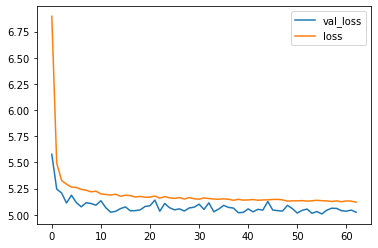

In [83]:
pd.DataFrame(new_lstm_model.history.history).plot()

Before

In [33]:
print(f"Train MSE: {mean_squared_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test, predictions_test)}")
print("\n")

Train MSE: 4.969913614190661


Dev MSE: 4.945778432599058


Test MSE: 6.295055842090074




In [44]:
print(f"Train MSE: {mean_squared_error(y_train[:,0], predictions_train[:,0])}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev[:,0], predictions_dev[:,0])}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test[:,0], predictions_test[:,0])}")
print("\n")

Train MSE: 4.74599425255844


Dev MSE: 4.731035827677298


Test MSE: 6.019047728168678




After

In [84]:
predictions_train = new_lstm_model.predict(X_train)
predictions_dev = new_lstm_model.predict(X_dev)
predictions_test = new_lstm_model.predict(X_test)

In [85]:
print(f"Train MSE: {mean_squared_error(y_train, predictions_train)}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev, predictions_dev)}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test, predictions_test)}")
print("\n")

Train MSE: 4.95538136361836


Dev MSE: 4.940342999651808


Test MSE: 6.276730994036989




In [86]:
print(f"Train MSE: {mean_squared_error(y_train[:,0], predictions_train[:,0])}")
print("\n")
print(f"Dev MSE: {mean_squared_error(y_dev[:,0], predictions_dev[:,0])}")
print("\n")
print(f"Test MSE: {mean_squared_error(y_test[:,0], predictions_test[:,0])}")
print("\n")

Train MSE: 4.730482401767526


Dev MSE: 4.723665276445934


Test MSE: 5.999519087571665




Bootstrap

In [92]:
y_train.shape

(44905, 5)

In [112]:
mse_array = []

for trial in range(10000):
    idx = np.random.choice(range(44905), 44905, replace=True)
    pred = predictions_train[:,0][idx]
    actual = y_train[:,0][idx]
    mse = mean_squared_error(actual, pred)
    mse_array.append(mse)

In [113]:
len(mse_array)

10000

In [114]:
np.mean(mse_array)

4.730373711883004

In [115]:
np.percentile(mse_array, 5)

4.606729960238266

In [116]:
np.percentile(mse_array, 95)

4.8551033894451825

In [117]:
np.std(mse_array)

0.0754483285802009

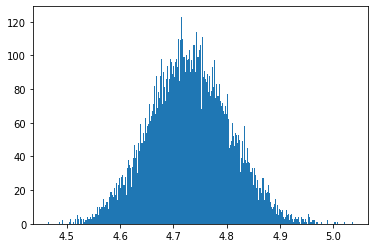

In [118]:
plt.hist(mse_array, bins=300)
plt.show()

__Conclusions__
- Some evidence that using odds data leads to improvement
- Caveats:
    - Old model trained on historal data which has a bug (team name = team name opponent)
    - Difference in dev MSE is very small - worth bootstrapping to get confidence bands